In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from IPython.display import display, Image
import ipywidgets as widgets
import threading
from typing import List, Tuple
from pathlib import Path

In [ ]:
# Stop button
# ================
stopButton = widgets.ToggleButton(
    value=False,
    description='Stop',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='square' # (FontAwesome names without the `fa-` prefix)
)


# Display function
# ================
def view(button):
    cap = cv2.VideoCapture(0)
    display_handle=display(None, display_id=True)
    i = 0
    while i<10000:
        _, frame = cap.read()
        frame = cv2.flip(frame, 1) # if your camera reverses your image
        _, frame = cv2.imencode('.jpeg', frame)
        display_handle.update(Image(data=frame.tobytes()))
        if stopButton.value==True:
            cap.release()
            display_handle.update(None)
        i += 1

            
# Run
# ================
display(stopButton)
thread = threading.Thread(target=view, args=(stopButton,))
thread.start()

ToggleButton(value=False, button_style='danger', description='Stop', icon='square', tooltip='Description')

Exception in thread Thread-5 (view):
Traceback (most recent call last):
  File "c:\Users\akoss\work\hunbug\repos\cam_cv\.conda\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "c:\Users\akoss\work\hunbug\repos\cam_cv\.conda\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\akoss\AppData\Local\Temp\ipykernel_20664\2798914048.py", line 22, in view
cv2.error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:1113: error: (-215:Assertion failed) !image.empty() in function 'cv::imencode'



In [4]:
# camera calibration
def find_checkerboard_corners(img: np.ndarray, pattern_size: Tuple[int, int], show_corners: bool = False) -> Tuple[np.ndarray, np.ndarray]:
    """
    Find the corners of a checkerboard in an image.
    :param img: The image to find the checkerboard in.
    :param pattern_size: The number of corners in the checkerboard.
    :param show_corners: Whether to show the image with the corners drawn on.
    :return: The image with the corners drawn on and the coordinates of the corners.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, pattern_size, None)
    if ret:
        if show_corners:
            img = img.copy()
            cv2.drawChessboardCorners(img, pattern_size, corners, ret)
    return img, corners


def get_checkerboard_3d(pattern_size: Tuple[int, int], square_size: float = 1.0) -> np.ndarray:
    """
    Get the 3D coordinates of the corners of a checkerboard.
    :param pattern_size: The number of corners in the checkerboard.
    :param square_size: The size of each square in the checkerboard.
    :return: The 3D coordinates of the corners.
    """
    objp = np.zeros((pattern_size[0] * pattern_size[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2) * square_size
    return objp


def calibrate_camera(images: List[np.ndarray], pattern_size: Tuple[int, int], show_corners: bool = False) -> Tuple[float, np.ndarray, np.ndarray, List[np.ndarray], List[np.ndarray]]:
    """
    Calibrate the camera using a set of images of a checkerboard.
    :param images: The images to use for calibration.
    :param pattern_size: The number of corners in the checkerboard.
    :param show_corners: Whether to show the images with the corners drawn on.
    :return: The camera matrix and distortion coefficients.
    """
    obj_points = []
    img_points = []
    objp = get_checkerboard_3d(pattern_size)
    for img in images:
        img, corners = find_checkerboard_corners(img, pattern_size, show_corners)
        if corners is not None:
            obj_points.append(objp)
            img_points.append(corners)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, images[0].shape[0:2], None, None)
    return ret, mtx, dist, rvecs, tvecs

def undistort_image(img: np.ndarray, mtx: np.ndarray, dist: np.ndarray) -> np.ndarray:
    """
    Undistort an image.
    :param img: The image to undistort.
    :param mtx: The camera matrix.
    :param dist: The distortion coefficients.
    :return: The undistorted image.
    """
    return cv2.undistort(img, mtx, dist, None, mtx)



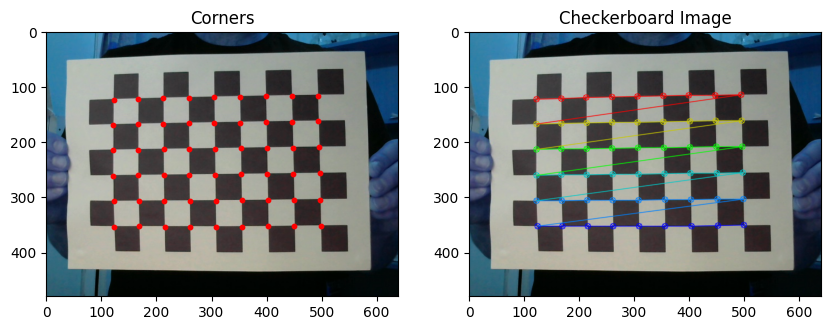

In [5]:
# test calibration on a single sample image

IMAGES_PATH = Path('../data')
IMAGE_NAME = Path('calibration1.jpg')

# read image
img = cv2.imread(str(IMAGES_PATH/IMAGE_NAME))

# find corners
img_checkerboard, corners = find_checkerboard_corners(img,pattern_size = (9,6), show_corners = True)

# draw original image and checkerboard and corners
fig, ax = plt.subplots(1,2, figsize = (10,10))
ax[0].imshow(img)
ax[0].set_title('Corners')
ax[1].imshow(img_checkerboard)
ax[1].set_title('Checkerboard Image')
for i in range(corners.shape[0]):
    ax[0].scatter(corners[i,:,0],corners[i,:,1], s = 10, c = 'r')
plt.show()


In [6]:
# calibrate camera
ret, mtx, dist, rvecs, tvecs = calibrate_camera([img], pattern_size=(9, 6))

# show calibration results
print('ret: ', ret)
print('mtx: ', mtx)
print('dist: ', dist)
print('rvecs: ', rvecs)
print('tvecs: ', tvecs)


ret:  0.23992120588601457
mtx:  [[1.41190742e+03 0.00000000e+00 2.09608670e+02]
 [0.00000000e+00 1.42747678e+03 2.13588372e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist:  [[-6.05265978e-01  8.41554213e+00  3.00288903e-03  3.39778338e-02
  -8.86803818e+01]]
rvecs:  (array([[0.13429319],
       [0.11758268],
       [3.1250984 ]]),)
tvecs:  (array([[ 6.0737534 ],
       [ 2.88667528],
       [29.77869896]]),)


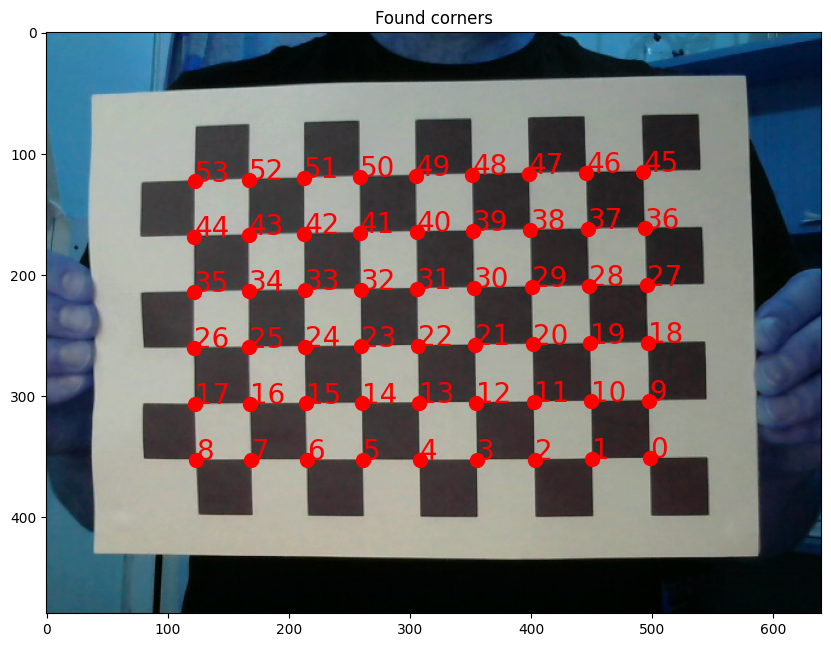

In [13]:
# DLT algorithm
# draw image and found corner points
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(img)
ax.scatter(corners[:, 0, 0], corners[:, 0, 1], s=100, c='r', marker='o')
# put numbers on the corners
for i, corner in enumerate(corners):
    ax.annotate(str(i), (corner[0, 0], corner[0, 1]), fontsize=20, color='r')
ax.set_title('Found corners')
plt.show()


In [23]:
world_points = get_checkerboard_3d((9, 6))
print(world_points)
print(corners.shape)
print(corners.reshape(-1, 2))

[[0. 0. 0.]
 [1. 0. 0.]
 [2. 0. 0.]
 [3. 0. 0.]
 [4. 0. 0.]
 [5. 0. 0.]
 [6. 0. 0.]
 [7. 0. 0.]
 [8. 0. 0.]
 [0. 1. 0.]
 [1. 1. 0.]
 [2. 1. 0.]
 [3. 1. 0.]
 [4. 1. 0.]
 [5. 1. 0.]
 [6. 1. 0.]
 [7. 1. 0.]
 [8. 1. 0.]
 [0. 2. 0.]
 [1. 2. 0.]
 [2. 2. 0.]
 [3. 2. 0.]
 [4. 2. 0.]
 [5. 2. 0.]
 [6. 2. 0.]
 [7. 2. 0.]
 [8. 2. 0.]
 [0. 3. 0.]
 [1. 3. 0.]
 [2. 3. 0.]
 [3. 3. 0.]
 [4. 3. 0.]
 [5. 3. 0.]
 [6. 3. 0.]
 [7. 3. 0.]
 [8. 3. 0.]
 [0. 4. 0.]
 [1. 4. 0.]
 [2. 4. 0.]
 [3. 4. 0.]
 [4. 4. 0.]
 [5. 4. 0.]
 [6. 4. 0.]
 [7. 4. 0.]
 [8. 4. 0.]
 [0. 5. 0.]
 [1. 5. 0.]
 [2. 5. 0.]
 [3. 5. 0.]
 [4. 5. 0.]
 [5. 5. 0.]
 [6. 5. 0.]
 [7. 5. 0.]
 [8. 5. 0.]]
(54, 1, 2)
[[498.2558   351.35498 ]
 [450.5002   351.9992  ]
 [402.91116  352.59952 ]
 [355.46976  352.92282 ]
 [308.00668  353.0439  ]
 [261.22934  352.90662 ]
 [215.02106  352.96994 ]
 [168.95712  352.65112 ]
 [123.666466 352.95654 ]
 [497.32516  303.79895 ]
 [449.7216   304.45724 ]
 [402.2625   304.92218 ]
 [354.5403   305.46036 ]
 [307.2726   30

In [27]:
# Do the DLT calibration for the camera
corners_flat = corners.reshape(-1, 2)
world_points_flat = world_points.reshape(-1, 3)
def get_camera_matrix(points2d, points3d):
    A = np.zeros((2 * points3d.shape[0], 12))
    print(A.shape)
    for i in range(points3d.shape[0]):
        x,y,z = points3d[i]
        u,v = points2d[i]
        # print(f"x={x}, y={y}, z={z}, u={u}, v={v}")
        A[2*i] = [x,y,z,1,0,0,0,0,-u*x,-u*y,-u*z,-u]
        A[2*i+1] = [0,0,0,0,x,y,z,1,-v*x,-v*y,-v*z,-v]

    # solve for the camera matrix using SVD
    _, _, V = np.linalg.svd(A)
    camera_matrix = V[-1, :].reshape(3, 4)
    return camera_matrix
camera_matrix = get_camera_matrix(corners_flat, world_points_flat)
print(camera_matrix)

(108, 12)
[[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0. -1.  0.]]


In [28]:
# Known 3D coordinates
xyz = [[-875, 0, 9.755], [442, 0, 9.755], [1921, 0, 9.755], [2951, 0.5, 9.755], [-4132, 0.5, 23.618],
[-876, 0, 23.618]]
# Known pixel coordinates
uv = [[76, 706], [702, 706], [1440, 706], [1867, 706], [264, 523], [625, 523]]
xyz_flat = np.array(xyz).reshape(-1, 3)
uv_flat = np.array(uv).reshape(-1, 2)
test_cam_mat= get_camera_matrix(uv_flat, xyz_flat)
print(test_cam_mat)


(12, 12)
[[ 2.69200328e-04 -2.39666715e-01  1.21265422e-01 -9.03245197e-01]
 [-6.95593157e-06 -4.52970262e-02  7.45394075e-02 -3.23100151e-01]
 [-9.85259430e-09 -6.41600936e-05  1.57185128e-04 -9.61057968e-04]]
